In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os

# Get the current research's directory
research_dir = os.path.dirname(os.path.abspath('__file__'))

# Move one directory back
parent_dir = os.path.dirname(research_dir)

# Change the current working directory to the parent directory
os.chdir(parent_dir)

# Print the current working directory to confirm
print(f"Current working directory: {os.getcwd()}")

# AutoGen Core + LangGraph

>https://microsoft.github.io/autogen/stable/user-guide/core-user-guide/framework/distributed-agent-runtime.html

>https://microsoft.github.io/autogen/stable/user-guide/core-user-guide/core-concepts/architecture.html

>https://devblogs.microsoft.com/semantic-kernel/semantic-kernel-and-autogen-part-2/

>https://github.com/Azure-Samples/az-ai-kickstarter


#### How Runtime AutoGen works
A distributed runtime, as shown in the diagram above, consists of a host servicer and multiple workers. The host servicer facilitates communication between agents across workers and maintains the states of connections. The workers run agents and communicate with the host servicer via gateways. They advertise to the host servicer the agents they run and manage the agents’ lifecycles.

Agents work the same way as in the standalone runtime so that developers can switch between the two runtime types with no change to their agent implementation.

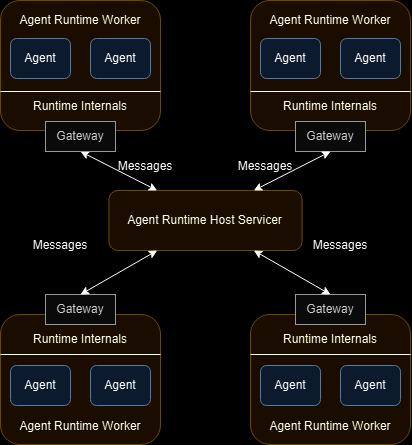


#### Shared Runtime Semantic-Kernel and AutoGen

A central design goal of this convergence effort is the adoption of a common runtime and interfaces. By aligning the execution model, both frameworks can leverage shared abstractions for agent orchestration and process management.

Semantic Kernel is adding connectors to support integrating agents from other services and libraries (such as OpenAI Assistant agent and Azure AI Agents) and now, with AutoGen agents

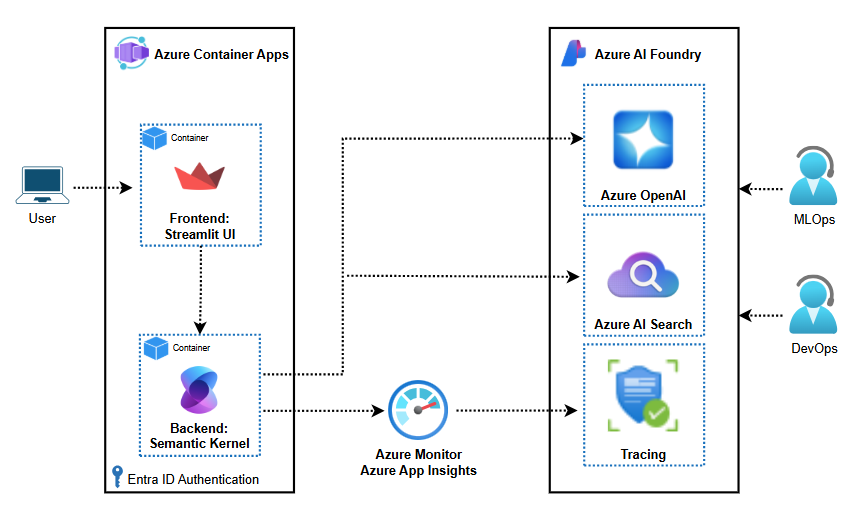


## AutoGen Core + OakLang Agent HITL + Opentelemetry tracing Azure AI Foundry

In [ ]:
from langgraph.types import Command
from langgraph.checkpoint.memory import MemorySaver

from frank.workflow_builder import WorkflowBuilder
from frank.config.layouts.oak_human_loop_config_graph import OakHumanLoopConfigGraph
from frank.entity.models.stategraph import SharedState
from frank.utils.common import read_yaml
from frank.utils.logger import setup_logging
from frank.constants import *

## Read the config.yaml
config = read_yaml(CONFIG_FILE_PATH)

## Setup logging Configuration
setup_logging(config)

## Workflow Configuration for the main graph
workflow_builder = WorkflowBuilder(
    config=OakHumanLoopConfigGraph, 
    state_schema=SharedState, 
    checkpointer=MemorySaver(),
)
graph = workflow_builder.compile() # compile the graph

In [ ]:
### Azure AI Inference Tracer
import os
from langchain_azure_ai.callbacks.tracers import AzureAIInferenceTracer

## MANAGE IDENTITY INSTEAD ENV
# from azure.ai.projects import AIProjectClient
# from azure.identity import DefaultAzureCredential # NOTE USE ASYNC DEFAULT CREDENTIALS

# project_client = AIProjectClient.from_connection_string(
#     credential=DefaultAzureCredential(),
#     conn_str="<your-project-connection-string>",
# )

## Runnable_Config + Langchain Tracer
langchain_tracer = AzureAIInferenceTracer(
    connection_string=os.environ["AZURE_APP_INSIGHT_CONNECTION_STRING"], # project_client.telemetry.get_connection_string()
    enable_content_recording=True,
)

runnable_config = {
    "configurable": {"thread_id": "001"}, 
    "callbacks": [langchain_tracer]}



In [ ]:
### AUTOGEN WRAPPER
from autogen_core import SingleThreadedAgentRuntime, AgentId
from frank.utils.autogen.langgraph_message_wrapper import LangGraphToolUseAgent, MessageWrapperAutogenState

runtime = SingleThreadedAgentRuntime()
await LangGraphToolUseAgent.register(
    runtime,
    "Frak-OakLang-Agent",
    lambda: LangGraphToolUseAgent(
        description="Tool to use OakLang Agent Assistant",
        graph=graph,
        runnable_config=runnable_config
    ),
)
agent = AgentId("Frak-OakLang-Agent", key="default")



In [ ]:
# Start the runtime
runtime.start()

# Example with regular message
response = await runtime.send_message(
    MessageWrapperAutogenState(content="What is the evolution of feebas? could you give me random movements of his evolution?"),
    agent
)
# Stop the runtime
await runtime.stop()

In [ ]:
response.content

In [ ]:
for event in response.events:
    print(event)
    print("\n")

# 🤖 LangGraph + AutoGen Core: Resumen

## 🧠 ¿Qué aporta cada uno?

### 📘 Ventajas de usar AutoGen con LangGraph

**AutoGen destaca por:**
- Gestión de múltiples agentes con roles definidos (`user_proxy`, `assistant`, `coder`, `critic`, etc.).
- Supervisor integrado para coordinar agentes automáticamente.
- Soporte para memoria, múltiples rondas y auto-detención.
- Ideal como "orquestadora" de agentes sobre un backend.

**LangGraph destaca por:**
- Flujos **determinísticos y controlables** mediante nodos y condiciones.
- Ideal para workflows estructurados, decisiones condicionales y visualización.
- Cada nodo puede representar un paso lógico o un agente.

## 🧩 Supervisor vs Orquestador de Agentes 

### 💡 ¿Cuál es la diferencia?

| Rol            | ¿Qué hace?                                                                 | Nivel                   | Equivalente humano                   |
|----------------|-----------------------------------------------------------------------------|--------------------------|--------------------------------------|
| **Supervisor** | Evalúa resultados, valida decisiones, interviene si algo sale mal.         | Operativo     | Jefe de equipo que revisa entregas   |
| **Orquestador**| Decide qué agentes participan, cuándo, en qué orden y cómo se comunican.   | Estrarégico | Director de proyecto                 |


### 📌 Key Points

- El **supervisor** suele ser un **agente dentro del sistema**, que actúa como evaluador o controlador de calidad.
- El **orquestador** es responsable de **diseñar y controlar el flujo general** de la interacción entre agentes.

---

## ¿Dónde es mejor ubicar un **supervisor**?

### Opción 1: **Supervisor en AutoGen**

**✅ Ventajas:**
- Supervisión reflexiva integrada de forma predeterminada.
- Maneja colaboración dinámica entre agentes sin necesidad de lógica explícita.
- Facilita la comunicación natural tipo "chat" entre múltiples agentes.

**❌ Contras:**
- Menor previsibilidad del flujo en entornos de producción controlada.
- Difícil de representar, visualizar, predecir o auditar paso a paso.

### Opción 2: **Supervisor en LangGraph**

**✅ Ventajas:**
- Control total del flujo, decisiones, loops, human review y routing.
- Ideal para despliegues críticos, donde la trazabilidad es clave.
- Fácil de visualizar y depurar.

**❌ Contras:**
- Tienes que codificar la lógica supervisora manualmente.
- Menos dinámico y espontaneidad en colaboración espontánea e interacción entre agentes.

---

## 🚀 ¿Qué hacer si quiero agentes personalizados con alta trazabilidad y un supervisor a medida?

### 🛠️ LangGraph como estructura de agentes
- Cada grafo es una tool con lógica definida.
- Ideal para sistemas robustos y predecibles.
- Mejor para funciones deterministas o tareas bien definidas.

### 🤝 AutoGen como coordinador de alto nivel

- AutoGen se encarga del flujo y supervisión.
- Dentro de cada agente, puedes usar LangGraph para definir su comportamiento interno.
- Ventajoso para casos donde la colaboración multiagentes requiere razonamiento fluido.

---

### 📌 Key Points

- Usa **AutoGen** si priorizas **colaboración natural, reflexiva y automatizada**.
- Usa **LangGraph** si quieres **control total del flujo y reglas personalizadas**.
- Para lo mejor de ambos mundos **combina LangGraph como tools complejas + AutoGen como capa de razonamiento y coordinación dinámica (supervisor).** Se empleará AutoGen para coordinación dinámica y razonamiento, mientras defines el comportamiento interno de cada agente con LangGraph.

# Semantic-Kernel + LangGraph

In [ ]:
from langgraph.checkpoint.memory import InMemorySaver
from frank.workflow_builder import WorkflowBuilder
from frank.config.layouts.simple_oak_config_graph import SimpleOakConfigGraph
from frank.entity.models.stategraph import SharedState
from frank.utils.common import read_yaml
from frank.utils.logger import setup_logging
from frank.constants import *

## Read the config.yaml
config = read_yaml(CONFIG_FILE_PATH)

## Setup logging Configuration
setup_logging(config)

## Workflow Configuration for the main graph
workflow_builder = WorkflowBuilder(
    config=SimpleOakConfigGraph, 
    state_schema=SharedState,
    checkpointer=InMemorySaver()
)
graph = workflow_builder.compile() # compile the graph

In [ ]:
from semantic_kernel.kernel import Kernel
from semantic_kernel.functions.kernel_function_decorator import kernel_function
from semantic_kernel.functions.kernel_plugin import KernelPlugin
from semantic_kernel.functions.kernel_arguments import KernelArguments

# 1. Define your plugin class with decorated methods
class LangGraphAgentPlugin:
    @kernel_function(name="RunGraphAgent", description="Execute Oak Professor Agent")
    async def run_graph(self, user_input: str) -> str:
        message_input = {"messages": [{"role": "human", "content": user_input}]}
        response = await graph.ainvoke(message_input, {"configurable": {"thread_id": "001"}})
        return response['messages'][-1].content

# 2. Create the Kernel and register the plugin using from_object
kernel = Kernel()
plugin = KernelPlugin.from_object("LangGraphAgentPlugin", LangGraphAgentPlugin())
kernel.add_plugin(plugin)

# 3. Execute the function as before
async def main():
    function = kernel.plugins["LangGraphAgentPlugin"]["RunGraphAgent"]
    # Convert dict to KernelArguments
    args = KernelArguments(user_input="Could you give me random movements of Pikachu, and what is his evolutions?")
    result = await kernel.invoke(
        function=function,
        arguments=args  # <- Pass KernelArguments, not a dict
    )
    print("Semantic-Kernel Response:", result)


await main()